In [1]:
#setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import timeit

In [2]:
#Read in data
df1 = pd.read_csv('../../../Sports betting arbitrage/data/raw/20190401-14_items.csv')
df2 = pd.read_csv('../../../Sports betting arbitrage/data/raw/20190415-28_items_csvedit.csv')
df3 = pd.read_csv('../../../Sports betting arbitrage/data/raw/20190428-0508_items_csvedit.csv')
df4 = pd.read_csv('../../../Sports betting arbitrage/data/raw/20191221-20200312_items.csv')
df = pd.concat([df1,df2,df3,df4], ignore_index=True)
del [df1,df2,df3,df4]

# Some exploration

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df.head(3)

,gametag,competition,eventname,volume,timestamp,current_gametime,current_score,market_name,pick_1,pick_X,pick_2,back_1,back_X,back_2,back_size_1,back_size_X,back_size_2,lay_1,lay_X,lay_2,lay_size_1,lay_size_X,lay_size_2,back_noscore,back_size_noscore,lay_noscore,lay_size_noscore
0,20190331_AJAPSV,Dutch Eredivisie,Ajax v PSV,"EUR 52,043",1554043958,4',0 - 0,NaN,Ajax,The Draw,PSV,1.69,4.7,5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20190331_AJAPSV,Dutch Eredivisie,Ajax v PSV,"EUR 53,341",1554044077,6',0 - 0,NaN,Ajax,The Draw,PSV,1.68,4.6,5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20190331_AJAPSV,Dutch Eredivisie,Ajax v PSV,"EUR 60,104",1554044201,9',0 - 0,NaN,Ajax,The Draw,PSV,1.67,4.6,5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have 144869 entries and 27 columns, and a little more over 1000 games. Although many of them have few and no ingame observations and will be cleaned out later.

In [5]:
df['eventname'].unique().size

1057

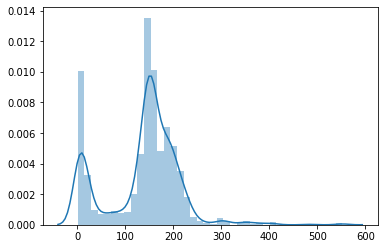

In [6]:
sns.distplot(df[['eventname','timestamp']].groupby('eventname').count())

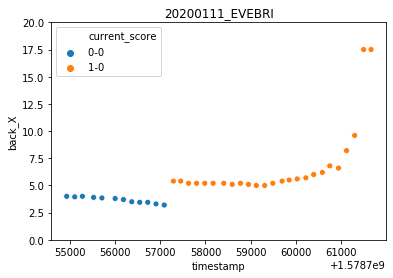

In [7]:
#test graph with slice
test = df[(df['gametag'] =='20200111_EVEBRI') & (df['market_name'] == 'Match Odds')]
scatter = sns.scatterplot(x='timestamp',y='back_X',data=test,hue='current_score')
axes = scatter.axes
axes.set_ylim(0,20)
#axes.set_xlim(1554835000,1554845000)
axes.set_title('20200111_EVEBRI')
axes.legend(loc='upper left')

# Some first data cleaning

#### extreme back quotes

Games with too few / no observations we'll clean later. First we filter out useless observations:
- 'Correct score' datapoints with noscore_back = 0
- datapoints from other markets with back_1, back_X or back_2 = 0

Quick check learns all of them are wrong or extreme observations; like backing a team leading 4-0 at the end of the game, or quotes just when the score changes...

In [8]:
#filter out useless observations #1
# from 144869 to 134072 records
df = df[((df['market_name'] != 'Correct Score') & ~((df['back_1'] == 0) | (df['back_X'] == 0) | (df['back_2'] == 0))) | 
   ((df['market_name'] == 'Correct Score') & ~((df['back_noscore'] == 0) | (df['lay_noscore'] == 0)))]
df.reset_index(drop=True,inplace=True)

#### implied margin

We define the implied margin as the loss you will make when betting on all 3 outcomes:

<img src="../0 images/impl_margin_formula.png">

This is always negative. Though mostly it is not too negative as the betfair platform does not make its profit from implied margins. So usually it is rather close to zero. However just after game events (goal, red card) when the quotes change significantly the implied_margin takes extreme values. We want to exclude these observations from the analysis as they do not actually represent quotes you can bet on.

In [9]:
df['back_impl_margin'] = 1 - (1/df['back_1']) - (1/df['back_X']) - (1/df['back_2'])
df['back_impl_margin'] = df['back_impl_margin'].round(4)

In [10]:
# from 134072 to 129383 records
df = df[((df['market_name'] == 'Match Odds') & (df['back_impl_margin'] >= -0.1)) | 
        (df['market_name'] == 'Correct Score') |
        ((df['market_name'] != 'Match Odds') & (df['market_name'] != 'Correct Score') & (df['back_impl_margin'] >= -0.15))]
df.reset_index(drop=True,inplace=True)

# Feature engineering

In what follows we will:
- make the gametime string to an integer: **current_gametime_T1**
- calculate the starttimes of the first and second half: **start1_calib** + **start2_calib**
- correct the gametime based on timestamp and starttimes, and fill null values: **current_gametime_T2**
- calculate the gap with the next and previous observation: **gap_prev** and **gap_next**
- fill null values for the current score: **current_score_T1**
- correct correct score for score confusion (change and back): **current_score_T1_prev**, **current_score_T1_next** and **current_score_T2**
- create boolean whether the home team is favourite or not, per observation: **F_home**
- create feature indicating the quote to back the favourite, per observation: **back_F**
- determine the "calibration" for every game: just before the start, was the home team favourite (**F_home_calib**), what was the back_F (**back_F_calib**) and what was the back_noscore (**back_noscore_calib**)
- clean out games who don't have F_home_calib, they do not have game observations
- create score labels in terms of goal lead for the favourite: F+0, F+1, F-1, F+2, ...: **score_diff_label**
- identify scoreless games (no goal was scored during the observations for this game): **scoreless**
- identify gametime when the first goal was scored: **firstgoal_GT**
- identify observations where a team takes the lead: **lead_shift**
- identify the change in the back_F quote relative to the previous observation in that same market: **back_F_rchange**
- identify quote shifts, based on back_F_rchange and some criterion (**rchange_crit**) relative to the back_F quote: **quote_shift**
- identify the observations closest to the 0,15,30,45,60,75th minute, per game: **mins_15**
- create endscore feature: **endscore**
- create endscore feature (in terms of score_diff_label): **endscore_label**

First we define some functions we will use for all this:

In [11]:
def gametime_to_int(gametime_string):
    if "'" in str(gametime_string):
        return int(gametime_string.split("'")[0])
    else:
        return np.nan

def starttime_calib(arr):
    """
    Function starttime_calib() calibrates the starttime timestamp for the first and second half: start1_calib and start2_calib
    It takes an array as input: with timestamps in the first and gametimes in the second column.
    It computes startdate estimates for each of the observations.
    The output is the average of these estimates.
    """
    #imports
    from datetime import datetime
    from datetime import timedelta
    
    #dropna
    arr = arr.dropna(axis=0)
    
    #first half
    arr1 = arr[arr.iloc[:,1]<45]
    if len(arr1) == 0:
        return np.nan, np.nan
    else:
        timestamps1 = arr1.iloc[:,0].apply(datetime.fromtimestamp)
        gametimes1 = arr1.iloc[:,1].apply(lambda x:timedelta(minutes=x+1))
        start1_estims =  timestamps1 - gametimes1
        start1_calib = round(datetime.timestamp(start1_estims.mean()))

    #second half
    est = datetime.timestamp(start1_estims.mean() + timedelta(minutes=60))
    arr2 = arr[arr.iloc[:,0]>est]
    if len(arr2) == 0:
        return start1_calib, np.nan
    else:
        timestamps2 = arr2.iloc[:,0].apply(datetime.fromtimestamp)
        gametimes2 = arr2.iloc[:,1].apply(lambda x:timedelta(minutes=x-44))
        start2_estims =  timestamps2 - gametimes2
        start2_calib = round(datetime.timestamp(start2_estims.mean()))

    return start1_calib, start2_calib

def compute_current_gametime_T2(df, gametag='gametag', timestamp='timestamp', market_name='market_name', start1_calib='start1_calib' , start2_calib='start2_calib'):
    """compute_current_gametime_T2
    Function makes a transformation of compute_current_gametime_T2 based in timestamp and starttimes:
    - current_gametime_T2 also gets a value if current_gametime_T1 = null
    - current_gametime_T2 can be negative (i.e. before start of the game)
    - all first-half observations at or above 45' are mapped to minute 45
    
    The function takes a Pandas dataframe with at least 5 columns as input. Default column names are: gametag, timestamp, market_name, start1_calib, start2_calib (gametag and market_name are needed for the NaN drop and join)
    The function gives 1 pandas Series of the same length as output: current_gametime_T2
    """
    
    #if there is no 'start1_calib' then there should be no current_gametime_T2
    df2 = df[[gametag, timestamp, market_name, start1_calib, start2_calib]].dropna(axis=0,subset=[start1_calib])
    
    #if there is no 'start2_calib' then there should be no current_gametime_T2 value for timestamps > 'start1_calib' + 60mins
    #for this logic we need 'start2_calib_sim' (enrichment8)
    df2['start2_calib_sim'] = df2[start2_calib]
    sim = df2[start1_calib].apply(datetime.fromtimestamp) + timedelta(minutes=60)
    sim = sim.apply(datetime.timestamp)
    df2['start2_calib_sim'].fillna(value=sim,inplace=True)
    
    #compute the delta's
    delta1 = df2[timestamp].apply(datetime.fromtimestamp) - df2[start1_calib].apply(datetime.fromtimestamp)
    delta2 = df2[timestamp].apply(datetime.fromtimestamp) - df2['start2_calib_sim'].apply(datetime.fromtimestamp)
    
    #broadcast delta1 for first and delta2 for second half
    df2.at[df2[timestamp] < df2['start2_calib_sim'],'computed'] = delta1.apply(timedelta.total_seconds) / 60
    df2.at[df2[timestamp] >= df2['start2_calib_sim'],'computed'] = (delta2.apply(timedelta.total_seconds) / 60) + 45
    df2 = df2[(~(df2[start2_calib].isna())) | (df2[timestamp] < df2['start2_calib_sim'])] #enrichment8
    df2['computed'] = df2['computed'].apply(round,0).apply(int) #20200412: first round, then make it integer
    df2.at[(df2[timestamp] < df2[start2_calib]) & (df2['computed'] >= 45),'computed'] = int(45)
    
    #merge
    df3 = pd.merge(df,df2,how='outer',on=[gametag,timestamp,market_name])
    #print(len(df3))
    
    return df3['computed']

def determine_Fhome(back_1, back_2):
    """
    Function compares back_1 (number) to back_2 (number). If back_1 <= back2, then Fhome (boolean) is True.
    If back_1 or back_2 is NaN then Fhome is NaN
    """
    if (np.isnan(back_1) | np.isnan(back_2) | (back_1==0) | (back_2==0)):
        return np.nan
    elif back_1 <= back_2:
        return True
    else:
        return False

def determine_Fback(back_1, back_2, F_home):
    """
    Function returns back_1 if F_home is True; back_2 if F_home is False.
    If F_home is NaN then back_F is NaN
    """
    if np.isnan(F_home):
        return np.nan
    elif F_home:
        return back_1
    else:
        return back_2

def determine_Uback(back_1, back_2, F_home):
    """
    Function returns back_1 if F_home is True; back_2 if F_home is False.
    If F_home is NaN then back_F is NaN
    """
    if np.isnan(F_home):
        return np.nan
    elif F_home:
        return back_2
    else:
        return back_1
    
def get_calib_idx(df, market_name='Match Odds'):
    """
    This function determines the index (row) number of the observation just before or after the start of the game.
    This observation can be used for calibration of the F, back_F and back_noscores variables per game.
    If there are observations before that start of the game, the one closest to the start will be chosen.
    If not, the first observation since the start of the game will be chosen.
    """
    df2 = df.loc[df['market_name'] == market_name,:]
    
    if len(df2[df2['timestamp'] <= df2['start1_calib']]) > 0:
        df2 = df2[df2['timestamp'] <= df2['start1_calib']]
        return df2['timestamp'].idxmax()
    elif len(df2[df2['timestamp'] > df2['start1_calib']]) > 0:
        return df2['timestamp'].idxmin()
    else:
        return np.nan

In [12]:
#['current_gametime_T1'] is the gametime string made to an integer
df['current_gametime_T1'] = df['current_gametime'].apply(gametime_to_int)

In [13]:
#['start1_calib'] en ['start2_calib'] are the start times of the first and second half
for gametag in df['gametag'].unique():
    arr = df[(df['gametag'] == gametag)][['timestamp','current_gametime_T1']]
    x,y = starttime_calib(arr)
    df.at[df['gametag'] == gametag,'start1_calib'] = x
    df.at[df['gametag'] == gametag,'start2_calib'] = y

In [14]:
#['current_gametime_T2'] is the gametime based on timestamp and starttimes
#[current_gametime_T2] heeft ook een waarde indien current_gametime = null, en is negatief voor de starttijd
df['current_gametime_T2'] = compute_current_gametime_T2(df)

In [15]:
#gap_next en gap_prev (takes long!)
start = timeit.default_timer()
print("to do: ",len(df['gametag'].unique()))
for (count,gametag) in enumerate(df['gametag'].unique()):
    print(count,"\r",end="")
    for market_name in df[df['gametag'] == gametag]['market_name'].unique():
        df.at[((df['market_name'] == market_name) & (df['gametag'] == gametag)),'timestamp_prev'] = df[((df['market_name'] == market_name) & (df['gametag'] == gametag))]['timestamp'].shift(periods=1,fill_value=np.nan)
        df.at[((df['market_name'] == market_name) & (df['gametag'] == gametag)),'timestamp_next'] = df[((df['market_name'] == market_name) & (df['gametag'] == gametag))]['timestamp'].shift(periods=-1,fill_value=np.nan)
stop = timeit.default_timer()
print('Runtime: ', stop - start)

to do:  1431
Runtime:  293.6349913


In [16]:
#gap_next en gap_prev
df.loc[:,'gap_prev'] = df['timestamp'] - df['timestamp_prev']
df.loc[:,'gap_next'] = df['timestamp_next'] - df['timestamp']

In [17]:
#current_score_T1: all observations with current_gametime_T2<0, have current score 0-0
df.loc[:,'current_score_T1'] = df['current_score'].str.strip()
df.at[df['current_gametime_T2']<0,'current_score_T1'] = '0-0'

In [18]:
#current_score_T1: forward fill na values
df.at[df['current_score_T1'] == '','current_score_T1'] = np.nan
df['current_score_T1'] = df.groupby('gametag')['current_score_T1'].fillna(method='ffill')

In [19]:
#current_score_T2 corrects for score confusion (takes long!)
start = timeit.default_timer()
print("to do: ",len(df['gametag'].unique()))
for (count,gametag) in enumerate(df['gametag'].unique()):
    print(count,"\r",end="")
    for market_name in df[df['gametag'] == gametag]['market_name'].unique():
        df.at[((df['market_name'] == market_name) & (df['gametag'] == gametag)),'current_score_T1_prev'] = df[((df['market_name'] == market_name) & (df['gametag'] == gametag))]['current_score_T1'].shift(periods=1,fill_value=np.nan)
        df.at[((df['market_name'] == market_name) & (df['gametag'] == gametag)),'current_score_T1_next'] = df[((df['market_name'] == market_name) & (df['gametag'] == gametag))]['current_score_T1'].shift(periods=-1,fill_value=np.nan)
stop = timeit.default_timer()
print('Runtime: ', stop - start)

to do:  1431
Runtime:  331.64455560000005


In [20]:
#current_score_T2 corrects for score confusion
#54 cases of confusion: df[(df['current_score_T1_prev'] == df['current_score_T1_next']) & (df['current_score_T1_prev'] != df['current_score_T1'])]
df['current_score_T2'] = df['current_score_T1']
df.at[((df['current_score_T1_prev'] == df['current_score_T1_next']) & (df['current_score_T1_prev'] != df['current_score_T1'])),'current_score_T2'] = np.nan
df['current_score_T2'] = df.groupby(['gametag','market_name'])['current_score_T2'].fillna(method='ffill')

In [21]:
#fill empty score values at beginning
df.at[((df['current_score_T1_prev'].isnull()) & (df['current_score_T1_next'] == '0-0') & (df['current_gametime_T2'] >= 0)),'current_score_T2'] = '0-0'

In [22]:
df[(df['gametag'] == '20190428_CLUAND') & (df['market_name'] == 'Match Odds')].iloc[0:5]

,gametag,competition,eventname,volume,timestamp,current_gametime,current_score,market_name,pick_1,pick_X,pick_2,back_1,back_X,back_2,back_size_1,back_size_X,back_size_2,lay_1,lay_X,lay_2,lay_size_1,lay_size_X,lay_size_2,back_noscore,back_size_noscore,lay_noscore,lay_size_noscore,back_impl_margin,current_gametime_T1,start1_calib,start2_calib,current_gametime_T2,timestamp_prev,timestamp_next,gap_prev,gap_next,current_score_T1,current_score_T1_prev,current_score_T1_next,current_score_T2
19481,20190428_CLUAND,Belgian First Division A,Club Brugge v Anderlecht,"EUR 16,741",1556467264,NaN,,Match Odds,Club Brugge,The Draw,Anderlecht,1.67,4.2,6.0,€458,€77,€161,1.68,4.3,6.2,€607,€384,€194,NaN,NaN,NaN,NaN,-0.0036,NaN,1.556467e+09,1.556471e+09,0.0,NaN,1.556468e+09,NaN,310.0,NaN,NaN,0-0,0-0
19485,20190428_CLUAND,Belgian First Division A,Club Brugge v Anderlecht,"EUR 18,831",1556467574,4',0-0,Match Odds,Club Brugge,The Draw,Anderlecht,1.67,4.2,5.9,€15,€100,€573,1.69,4.3,6.0,€582,€11,€109,NaN,NaN,NaN,NaN,-0.0064,4.0,1.556467e+09,1.556471e+09,5.0,1.556467e+09,1.556468e+09,310.0,156.0,0-0,NaN,0-0,0-0
19488,20190428_CLUAND,Belgian First Division A,Club Brugge v Anderlecht,"EUR 20,359",1556467730,6',0-0,Match Odds,Club Brugge,The Draw,Anderlecht,1.68,4.1,5.8,€278,€53,€862,1.70,4.2,6.2,€182,€64,€53,NaN,NaN,NaN,NaN,-0.0116,6.0,1.556467e+09,1.556471e+09,7.0,1.556468e+09,1.556468e+09,156.0,361.0,0-0,0-0,0-0,0-0
19492,20190428_CLUAND,Belgian First Division A,Club Brugge v Anderlecht,"EUR 22,959",1556468091,12',0-0,Match Odds,Club Brugge,The Draw,Anderlecht,1.69,4.1,5.7,€251,€92,€119,1.70,4.2,6.2,€25,€199,€571,NaN,NaN,NaN,NaN,-0.0111,12.0,1.556467e+09,1.556471e+09,13.0,1.556468e+09,1.556468e+09,361.0,113.0,0-0,0-0,0-0,0-0
19494,20190428_CLUAND,Belgian First Division A,Club Brugge v Anderlecht,"EUR 23,964",1556468204,15',0-0,Match Odds,Club Brugge,The Draw,Anderlecht,1.68,4.1,5.7,€1527,€36,€22,1.70,4.2,5.9,€35,€320,€576,NaN,NaN,NaN,NaN,-0.0146,15.0,1.556467e+09,1.556471e+09,15.0,1.556468e+09,1.556469e+09,113.0,369.0,0-0,0-0,0-0,0-0


In [23]:
#['F_home'] is the boolean whether the home team is favourite for this observation or not
df.loc[:,'F_home'] = df.apply(lambda x: determine_Fhome(x['back_1'], x['back_2']), axis=1)

In [24]:
#['back_F'] is the quote to back the favourite
start = timeit.default_timer()
df.loc[:,'back_F'] = df.apply(lambda x: determine_Fback(x['back_1'], x['back_2'], x['F_home']), axis=1)
df.loc[:,'back_U'] = df.apply(lambda x: determine_Uback(x['back_1'], x['back_2'], x['F_home']), axis=1)
stop = timeit.default_timer()
print('Runtime: ', stop - start)

Runtime:  8.527826100000084


In [25]:
#['F_home_calib'] is the calibration for F_home; was the home team favourite before the start of the game?
#['back_F_calib'] is the calibration for back_F; the back_F quote before the start of the game
#['back_noscore_calib'] is the calibration for back_noscore; the back_noscore quote before the start of the game
start = timeit.default_timer()
print("to do: ",len(df['gametag'].unique()))
for (count,gametag) in enumerate(df['gametag'].unique()):
    print(count,"\r",end="")
    idx_matchodds = get_calib_idx(df[(df['gametag'] == gametag)], market_name = 'Match Odds')
    idx_correctscore = get_calib_idx(df[(df['gametag'] == gametag)], market_name = 'Correct Score')
    if not np.isnan(idx_matchodds):
        df.at[df['gametag'] == gametag,'F_home_calib'] = df.iloc[idx_matchodds]['F_home']
        df.at[df['gametag'] == gametag,'back_F_calib'] = df.iloc[idx_matchodds]['back_F']    
    if not np.isnan(idx_correctscore):
        df.at[df['gametag'] == gametag,'back_noscore_calib'] = df.iloc[idx_correctscore]['back_noscore']
stop = timeit.default_timer()
print('Runtime: ', stop - start)

to do:  1431
Runtime:  55.881146400000034


In [26]:
#filter wedstrijden die geen F_home_calib hebben eruit, die hebben geen wedstrijd observaties
df = df[df['F_home_calib'].notna()]
df.reset_index(drop=True,inplace=True)

863  wedstrijden,  121883  observaties.


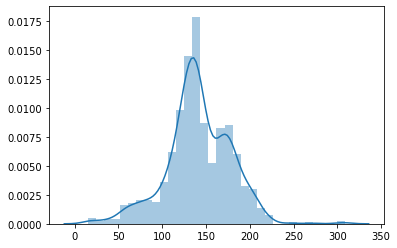

In [27]:
#hier verwachten we 863 wedstrijden en 121883 observaties
print(len(df['gametag'].unique())," wedstrijden, ",df['F_home_calib'].count()," observaties.")
sns.distplot(df[['gametag','timestamp']].groupby('gametag').count())

In [28]:
def determine_score_diff_label(current_score, F_home):
    """
    Input: current score, format: 2-3; F_home: boolean whether home team is the favourite or not
    Output: score difference label: F+0, F+1, F-1, F+2, ...
    If current_score, F_home are NaN or do not have the required format function will return NaN
    """
    if not ((type(F_home) == bool) & (type(current_score) == str)):
        return np.nan
    elif not ("-" in current_score):
        return np.nan
    else:
        home = int(current_score.split('-')[0])
        away = int(current_score.split('-')[1])
        fav = home if F_home else away
        udog = away if F_home else home
        
        if fav == udog:
            label = 'F+0'
        elif fav > udog:
            label = 'F+' + str(fav-udog)
        else:
            label = 'F-' + str(udog-fav)
        return label

In [29]:
#['score_diff_label'] labels the score in terms of goal lead for the favourite: F+0, F+1, F-1, F+2, ...
df.loc[:,'score_diff_label'] = df.apply(lambda x: determine_score_diff_label(x['current_score_T2'], x['F_home_calib']), axis=1)

In [30]:
def determine_scoreless(df):
    """
    Function determines whether game ended without goal being scored. 
    If all observations in df have 'current_score_T2' = '0-0', then scoreless (boolean) is True.
    If no 'current_score_T2' values, then scoreless is NaN
    """
    df = df.loc[df['current_score_T2'].notna(),:]
    
    if len(df) > 0:
        df2 = df[df['current_score_T2'] != '0-0']
        if len(df2) > 0:
            return False
        else:
            return True
    else:
        return np.nan

In [31]:
#a game is scoreless if no goal was scored during the observations for this game 
for gametag in df['gametag'].unique():
    scoreless = determine_scoreless(df[df['gametag'] ==gametag])
    if not np.isnan(scoreless):
        df.at[df['gametag'] == gametag,'scoreless'] = scoreless

In [32]:
#we expect 65 scoreless games out of 863 (7,5%)
temp = df[['gametag','scoreless']].groupby('gametag').min()
temp['scoreless'].value_counts()

False    798
True      65
Name: scoreless, dtype: int64

Thanks to the data cleaning also correctly labeled as scoreless:
- '20200104_WOLMAN'
- 0190428_SEALOS & 20200216_UDIVER (cleaning based on impl_margin)
- 20200216_UDIVER
- 20190414_SASPAR, 20191222_REAATH, KORCER, ZARFUE, WOLLEI, GETCEL, BELFAM (current_score_T2)
- 20190428_LEEAST & 20190428_SEALOS not scoreless (making scoreless based on current_score_T2 instead of score_diff_label)

In [33]:
def get_firstgoal_idx(df):
    """
    This function determines the index (row) number of the observation just after the first goal is made,
    i.e. when score_diff_label changes for the first time from F+0 to F+1 or F-1 in df
    input df should already be sliced to 1 event, and needs to have column names: market_name,score_diff_label,timestamp
    """
    df2 = df.loc[df['score_diff_label'].notna() & (~df['scoreless'].astype(bool)),:]
    df2 = df2[df2['score_diff_label'] != 'F+0']
    
    if len(df2) > 0:
        return df2['timestamp'].idxmin()
    else:
        return np.nan

In [34]:
#['firstgoal_GT'] is the gametime when the first goal was scored
for gametag in df['gametag'].unique():
    idx_firstgoal = get_firstgoal_idx(df[df['gametag'] ==gametag])
    if not np.isnan(idx_firstgoal):
        df.at[df['gametag'] == gametag,'firstgoal_GT'] = df.iloc[idx_firstgoal]['current_gametime_T2']

In [35]:
#enrichment11: we expect the first goal in '20190421_VILLEG' to be in minute 64
df[df['gametag'] == '20190421_VILLEG']['firstgoal_GT'].mean()

64.0

In [36]:
#we expect the mean of first goal gametime to be 31.91
df[['gametag','firstgoal_GT']].groupby('gametag').max().mean()

firstgoal_GT    31.928392
dtype: float64

In [37]:
#score_diff_label_prev (takes long!)
start = timeit.default_timer()
print("to do: ",len(df['gametag'].unique()))
for (count,gametag) in enumerate(df['gametag'].unique()):
    print(count,"\r",end="")
    for market_name in df[df['gametag'] == gametag]['market_name'].unique():
        df.at[((df['market_name'] == market_name) & (df['gametag'] == gametag)),'score_diff_label_prev'] = df[((df['market_name'] == market_name) & (df['gametag'] == gametag))]['score_diff_label'].shift(periods=1,fill_value=np.nan)
stop = timeit.default_timer()
print('Runtime: ', stop - start)

to do:  863
Runtime:  128.6173705000001


In [38]:
#lead_shift
df.at[:,'lead_shift'] = ((df['score_diff_label_prev'] == 'F+0') & 
                         (df['score_diff_label'] != 'F+0') & 
                         ~(df['score_diff_label'].isna()))

In [39]:
#back_F_prev
#edit data enrichtment10 for shifts in favourite
start = timeit.default_timer()
print("to do: ",len(df['gametag'].unique()))
for (count,gametag) in enumerate(df['gametag'].unique()):
    print(count,"\r",end="")
    for market_name in df[(df['gametag'] == gametag) & (df['market_name'] != 'Correct Score')]['market_name'].unique():
        df.at[((df['market_name'] == market_name) & (df['gametag'] == gametag)),'back_1_prev'] = df[((df['market_name'] == market_name) & (df['gametag'] == gametag))]['back_1'].shift()
        df.at[((df['market_name'] == market_name) & (df['gametag'] == gametag)),'back_2_prev'] = df[((df['market_name'] == market_name) & (df['gametag'] == gametag))]['back_2'].shift()
        df.at[((df['market_name'] == market_name) & (df['gametag'] == gametag) & (df['F_home'].astype(bool))),'back_F_prev'] = df[((df['market_name'] == market_name) & (df['gametag'] == gametag) & (df['F_home'].astype(bool)))]['back_1_prev']
        df.at[((df['market_name'] == market_name) & (df['gametag'] == gametag) & (~df['F_home'].astype(bool))),'back_F_prev'] = df[((df['market_name'] == market_name) & (df['gametag'] == gametag) & (~df['F_home'].astype(bool)))]['back_2_prev']
stop = timeit.default_timer()
print('Runtime: ', stop - start)

to do:  863
Runtime:  346.3231409000001


In [40]:
#back_F_rchange
df.at[:,'back_F_rchange'] = df['back_F']/df['back_F_prev']-1
df['back_F_rchange'] = df['back_F_rchange'].round(4)

In [41]:
#rchange_crit
rchange_crit_base = 0.15
factor1 = 2/3 #for F_back <= 1.25 -> crit becomes 0.10
factor2 = 0.80 #for F_back > 1.25 and <=1.40 -> crit becomes 0.12
factor3 = 2.5 #for gametime_T2 > 75 and <= 90 -> base_crit becomes 0.375
factor4 = 4.5 #for gametime_T2 > 90 -> base_crit becomes 0.675
df.at[:,'rchange_crit'] = rchange_crit_base
df.at[(df['back_F'] <= 1.25),'rchange_crit'] = round(rchange_crit_base * factor1,2)
df.at[((df['back_F_calib'] > 1.25) & (df['back_F_calib'] <= 1.40)),'rchange_crit'] = rchange_crit_base * factor2
df.at[((df['current_gametime_T2'] > 75) & (df['current_gametime_T2'] <= 90)),'rchange_crit'] = rchange_crit_base * factor3
df.at[((df['current_gametime_T2'] > 90)),'rchange_crit'] = round(rchange_crit_base * factor4,2)

In [42]:
#quote_shift
df.at[:,'quote_shift'] = df['back_F_rchange'].abs() >= df['rchange_crit']

In [43]:
df[(df['gametag']=='20190403_GENINT') & (df['market_name'] == 'Match Odds')].iloc[5:7]

,gametag,competition,eventname,volume,timestamp,current_gametime,current_score,market_name,pick_1,pick_X,pick_2,back_1,back_X,back_2,back_size_1,back_size_X,back_size_2,lay_1,lay_X,lay_2,lay_size_1,lay_size_X,lay_size_2,back_noscore,back_size_noscore,lay_noscore,lay_size_noscore,back_impl_margin,current_gametime_T1,start1_calib,start2_calib,current_gametime_T2,timestamp_prev,timestamp_next,gap_prev,gap_next,current_score_T1,current_score_T1_prev,current_score_T1_next,current_score_T2,F_home,back_F,back_U,F_home_calib,back_F_calib,back_noscore_calib,score_diff_label,scoreless,firstgoal_GT,score_diff_label_prev,lead_shift,back_1_prev,back_2_prev,back_F_prev,back_F_rchange,rchange_crit,quote_shift
1609,20190403_GENINT,Italian Serie A,Genoa v Inter,"EUR 248,291",1554318960,13',0-0,Match Odds,Genoa,The Draw,Inter,4.8,3.7,1.90,€664,€845,€26,4.9,3.75,1.92,€442,€341,€437,NaN,NaN,NaN,NaN,-0.0049,13.0,1.554318e+09,1.554322e+09,14.0,1.554319e+09,1.554319e+09,176.0,167.0,0-0,0-0,0-1,0-0,False,1.90,4.8,False,1.96,13.0,F+0,False,15.0,F+0,False,4.6,1.88,1.88,0.0106,0.15,False
1613,20190403_GENINT,Italian Serie A,Genoa v Inter,"EUR 252,064",1554319127,16',0-1,Match Odds,Genoa,The Draw,Inter,10.5,5.4,1.37,€11,€608,€45,12.0,5.50,1.38,€20,€390,€22,NaN,NaN,NaN,NaN,-0.0104,16.0,1.554318e+09,1.554322e+09,17.0,1.554319e+09,1.554319e+09,167.0,130.0,0-1,0-0,0-1,0-1,False,1.37,10.5,False,1.96,13.0,F+1,False,15.0,F+0,True,4.8,1.90,1.90,-0.2789,0.15,True


In [44]:
df[(df['gametag']=='20190403_GENINT') & (df['market_name'] == 'Match Odds')].iloc[13:15]

,gametag,competition,eventname,volume,timestamp,current_gametime,current_score,market_name,pick_1,pick_X,pick_2,back_1,back_X,back_2,back_size_1,back_size_X,back_size_2,lay_1,lay_X,lay_2,lay_size_1,lay_size_X,lay_size_2,back_noscore,back_size_noscore,lay_noscore,lay_size_noscore,back_impl_margin,current_gametime_T1,start1_calib,start2_calib,current_gametime_T2,timestamp_prev,timestamp_next,gap_prev,gap_next,current_score_T1,current_score_T1_prev,current_score_T1_next,current_score_T2,F_home,back_F,back_U,F_home_calib,back_F_calib,back_noscore_calib,score_diff_label,scoreless,firstgoal_GT,score_diff_label_prev,lead_shift,back_1_prev,back_2_prev,back_F_prev,back_F_rchange,rchange_crit,quote_shift
1637,20190403_GENINT,Italian Serie A,Genoa v Inter,"EUR 327,973",1554320321,36',0-1,Match Odds,Genoa,The Draw,Inter,17.0,5.8,1.29,€198,€927,€215,19.0,6.0,1.30,€103,€2468,€364,NaN,NaN,NaN,NaN,-0.0064,36.0,1.554318e+09,1.554322e+09,37.0,1.554320e+09,1.554321e+09,237.0,302.0,0-1,0-1,0-2,0-1,False,1.29,17.0,False,1.96,13.0,F+1,False,15.0,F+1,False,16.0,1.29,1.29,0.0000,0.15,False
1641,20190403_GENINT,Italian Serie A,Genoa v Inter,"EUR 342,455",1554320623,41',0-2,Match Odds,Genoa,The Draw,Inter,120.0,29.0,1.03,€17,€10911,€43,850.0,46.0,1.04,€26,€5949,€21,NaN,NaN,NaN,NaN,-0.0137,41.0,1.554318e+09,1.554322e+09,42.0,1.554320e+09,1.554321e+09,302.0,129.0,0-2,0-1,0-2,0-2,False,1.03,120.0,False,1.96,13.0,F+2,False,15.0,F+1,False,17.0,1.29,1.29,-0.2016,0.10,True


In [45]:
#'mins15'
#edit1: there must be a score/score_diff_label
#edit2 (enrichment7): change criteria for the first label (value 0)
start = timeit.default_timer()
df.loc[:,'mins15'] = np.nan
tolerance_seconds = 150
print("to do: ",len(df['gametag'].unique()))
for (count,gametag) in enumerate(df['gametag'].unique()):
    print(count,"\r",end="")
    for half in [1,2]:
        start_calib_colname = 'start' + str(half) + '_calib'
        for mins in np.arange(0,45,15):
            df2 = df[(df['market_name'] == 'Match Odds') & (df['gametag'] == gametag)]
            if len(df2[start_calib_colname].dropna()) > 0:
                mins_timestamp = datetime.timestamp(datetime.fromtimestamp(df2[start_calib_colname].mean()) + timedelta(minutes=int(mins)))
                if (mins == 0) & (half ==1):
                    tol = datetime.timestamp(datetime.fromtimestamp(mins_timestamp) + timedelta(seconds=int(tolerance_seconds+90)))
                    df3 = df2[(df2['timestamp'] < tol) & (df2['score_diff_label'] == 'F+0')]
                else:
                    df3 = df2[((df2['timestamp']-mins_timestamp).abs() <= tolerance_seconds) & ~(df2['score_diff_label'].isna())]
                if len(df3) > 0:
                    row = (df3['timestamp'] - mins_timestamp).abs().idxmin()
                    df.loc[row,'mins15'] = mins + (half-1)*45
stop = timeit.default_timer()
print('Runtime: ', stop - start)

to do:  863
Runtime:  86.28129890000014


In [46]:
df['mins15'].value_counts()

0.0     840
15.0    829
30.0    826
45.0    812
60.0    780
75.0    730
Name: mins15, dtype: int64

In [110]:
#endscore and endscore_label
endscores = df.groupby("gametag").tail(1)[['gametag','current_score_T2','score_diff_label']]
endscores.columns = ['gametag','endscore','endscore_label']
endscores.head()

,gametag,endscore,endscore_label
270,20190401_ARSNEW,2-0,F+2
579,20190401_ST NIM,2-1,F+1
883,20190402_AC UDI,1-1,F+0
1059,20190402_CAGJUV,0-2,F+2
1171,20190402_WATFUL,3-1,F+2


### Sidestep: correction of some endscores

From 20190406_BARATL we have discovered that for quite some games, we don't have observations till the end of the game. For most of these games the scraping was stopped intentionally, because the score difference was big enough and the remainder of the game was irrelevant to the lay the draw strategy outcomes. But for some games, the data scraping has been stopped unintentionally. This leads to incorrectly derived endscores, distorting the analysis. Here we will correct for this by overwriting the endscores and endscore labels for games with the last observation earlier than the 85th minute, and a score difference of less than 2 (F+0, F+1 or F-1).

In [111]:
last_obs = pd.DataFrame(df.groupby('gametag')['current_gametime_T2'].max())
endscore_labels = pd.DataFrame(endscores[endscores['gametag'].isin(last_obs[last_obs['current_gametime_T2'] < 85].index)].groupby('gametag')['endscore_label'].min())
earlystops = endscore_labels[endscore_labels['endscore_label'].isin(['F+0','F+1','F-1'])] #29 games
endscores_sub = pd.DataFrame(endscores[endscores['gametag'].isin(last_obs[last_obs['current_gametime_T2'] < 85].index)].groupby('gametag')['endscore'].min())
earlystops = earlystops.merge(endscores_sub,how='inner',on='gametag')
earlystops = earlystops.merge(last_obs,how='inner',on='gametag')
F_home_calibs = pd.DataFrame(df.groupby('gametag')['F_home_calib'].max())
earlystops = earlystops.merge(F_home_calibs,how='inner',on='gametag')

In [112]:
#actual endscores
earlystops.loc['20190406_BARATL','actual_endscore'] = '2-0'
earlystops.loc['20191226_KORCER','actual_endscore'] = '1-0'
earlystops.loc['20200125_BREAMI','actual_endscore'] = '2-1'
earlystops.loc['20200126_WILPEC','actual_endscore'] = '0-0'
earlystops.loc['20200209_MALNUM','actual_endscore'] = '2-1'
earlystops.loc['20200222_ANGMON','actual_endscore'] = '1-0'
earlystops.loc['20200222_DIJMON','actual_endscore'] = '1-1'
earlystops.loc['20200222_STRAMI','actual_endscore'] = '0-0'
earlystops.loc['20200222_TONRIO','actual_endscore'] = '1-2'
earlystops.loc['20200229_GRESTU','actual_endscore'] = '2-0'
earlystops.loc['20200301_SEACHI','actual_endscore'] = '2-1'
earlystops.loc['20190415_WATARS','actual_endscore'] = '0-1'
earlystops.loc['20200311_ST HEA','actual_endscore'] = '1-0'
earlystops.loc['20190505_GUICD ','actual_endscore'] = '2-2'
earlystops.loc['20200126_LILPAR','actual_endscore'] = '0-2'
earlystops.loc['20200229_EIBLEV','actual_endscore'] = '3-0'
earlystops.loc['20200229_ERZHAM','actual_endscore'] = '3-0'
earlystops.loc['20190403_ATHLEV','actual_endscore'] = '3-2'
earlystops.loc['20200104_GUIBEN','actual_endscore'] = '0-1'
earlystops.loc['20191227_BESGEN','actual_endscore'] = '4-1'
earlystops.loc['20190406_RAYVAL','actual_endscore'] = '2-0'
earlystops.loc['20190414_EINAUG','actual_endscore'] = '1-3'
earlystops.loc['20190506_SETBOA','actual_endscore'] = '0-3'
earlystops.loc['20200117_SPOBEN','actual_endscore'] = '0-2'
earlystops.loc['20200202_WILHER','actual_endscore'] = '1-0'
earlystops.loc['20200110_MORPOR','actual_endscore'] = '2-4'
earlystops.loc['20200105_GILWES','actual_endscore'] = '0-2'
earlystops.loc['20200308_ALCMIR','actual_endscore'] = '1-2'
earlystops.loc['20200202_VARPOR','actual_endscore'] = '0-2'

In [113]:
earlystops.loc[:,'actual_endscore_label'] = earlystops.apply(lambda x: determine_score_diff_label(x['actual_endscore'], x['F_home_calib']), axis=1)
earlystops

,endscore_label,endscore,current_gametime_T2,F_home_calib,actual_endscore,actual_endscore_label
gametag,,,,,,
20190403_ATHLEV,F+1,2-1,64.0,True,3-2,F+1
20190406_BARATL,F+0,0-0,54.0,True,2-0,F+2
20190406_RAYVAL,F-1,1-0,72.0,False,2-0,F-2
20190414_EINAUG,F-1,1-2,78.0,True,1-3,F-2
20190415_WATARS,F+1,0-1,41.0,False,0-1,F+1
20190505_GUICD,F+1,1-0,56.0,True,2-2,F+0
20190506_SETBOA,F-1,0-1,79.0,True,0-3,F-3
20191226_KORCER,F+0,0-0,74.0,True,1-0,F+1
20191227_BESGEN,F+1,2-1,69.0,True,4-1,F+3


In [114]:
endscores_update = endscores.copy()
endscores_update.loc[endscores_update['gametag'].isin(earlystops.index),
                     'endscore'] = earlystops['actual_endscore'].tolist()
endscores_update.loc[endscores_update['gametag'].isin(earlystops.index),
                     'endscore_label'] = earlystops['actual_endscore_label'].tolist()

In [115]:
#23 games have been updates -> correct
(~(endscores_update['endscore'] == endscores['endscore'])).sum()

23

In [117]:
endscores_update.head()

,gametag,endscore,endscore_label
270,20190401_ARSNEW,2-0,F+2
579,20190401_ST NIM,2-1,F+1
883,20190402_AC UDI,1-1,F+0
1059,20190402_CAGJUV,0-2,F+2
1171,20190402_WATFUL,3-1,F+2


In [119]:
endscores[endscores['gametag'] == '20190406_BARATL']

,gametag,endscore,endscore_label
3338,20190406_BARATL,0-0,F+0


In [118]:
endscores_update[endscores_update['gametag'] == '20190406_BARATL']

,gametag,endscore,endscore_label
3338,20190406_BARATL,2-0,F+2


In [120]:
#add endscores and endscore_labels to df
df = pd.merge(df,endscores_update,on='gametag')

## The end: store prepped dataset

In [121]:
df.to_csv('20190401-20200312_items_prepped.csv',index=False)

In [122]:
df_subset = df[df['market_name']=='Match Odds'][['gametag','pick_1','pick_2','back_1','back_X','back_2','back_impl_margin',
                                    'current_gametime_T2','current_score','current_score_T1_prev','current_score_T1_next',
                                    'current_score_T2','F_home','back_F',
                                     'back_U','F_home_calib','back_F_calib','back_noscore_calib','score_diff_label',
                                     'score_diff_label_prev','lead_shift','back_1_prev','back_2_prev','back_F_prev',
                                     'back_F_rchange','rchange_crit','quote_shift','mins15']]

In [123]:
df_subset.to_csv('20190401-20200312_items_subset_prepped.csv',index=False)

In [2]:
#df = pd.read_csv('20190401-20200312_items_prepped.csv')